### **8. Dragon Net**

In previous sections, we reviewed quite a large amount of work utilizing machine learning or deep learning based approaches to estimate ATE and HTE. To guarantee the consistency and asymptotic convergence rate of the treatment effect estimator, the underlying models are often required to satisfy certain convergence rate. For example, in double machine learning (DML) [9], the treatment effect estimator is asymptotically normal when both the propensity score and outcome regression models satisfy a convergence rate $o(n^{-1/4})$. Most of the existing work can be summarized into a two-stage estimation structure: In stage 1, we fit the models for the propensity score and expected outcome; In stage 2, we plug in the estimated models to formalize the final estimator of interest, such as ATE, HTE, ATT (averaged treatment effect on the treated), etc.

Despite the versatile choices of ML-based methods in both stages, there seems to be no targeted criteria about which model can serve for the best performance of the treatment effect estimation in stage 2. Therefore, Dragonnet [8] aims to answer this question: how can we adapt the design and training of the neural networks used in the first step in order to improve the quality of treatment effect estimation?

The author addressed this problem from two angles:

1. Based on the sufficiency of the propensity score for causal estimation, the author designed an innovative neural network structure, named as Dragonnet, so as to discard the irrelevant information in observational data and thus improve the quality of treatment effect estimation;

2. Starting from the non-parametric theory, the author utilized targeted minimum loss estimation (TMLE) procedure to imporve the finite sample stability of the final estimator.

In the rest of this section, we will introduce the above two innovations parts in details, and use a real data example to illustrate the estimation procedure.

#### Part 1: Dragonnet
Define the conditional outcome as $Q(a,s)=E[R|a,s]$ amd propensity score $g(s)=P(A=1|S=s)$. Our goal is to estimate the effect of treatment $A=1$ versus $A=0$, i.e.
\begin{equation}
    \text{HTE}_{\text{Dragonnet}}(s)=E[R(1)|S=s]-E[R(0)|S=s],
\end{equation}
and the average treatment effect 
\begin{equation}
    \text{ATE}_{\text{Dragonnet}}=E\Big[E[R(1)|S]-E[R(0)|S]\Big].
\end{equation}

Under certain identifiability assumptions, the HTE can be estimated by
\begin{equation}
    \widehat{\text{HTE}}_{\text{Dragonnet}}(s)=\hat{E}[R|A=1,S=s]-\hat{E}[R|A=0,S=s]=\hat{Q}(1,s)-\hat{Q}(1,s).
\end{equation}


According to the sufficiency of propensity score (Theorem 2.1 in [8]), all of the information in $S$ that is useful in estimating ATE is contained in $g(S)$. In other words, we should train $\hat{Q}(a,s)$ only through the information in $g(S)$, instead of the entire $S$. To achieve so, the author proposed a novel three-headed archetecture, which is shown in Figure 1 below.

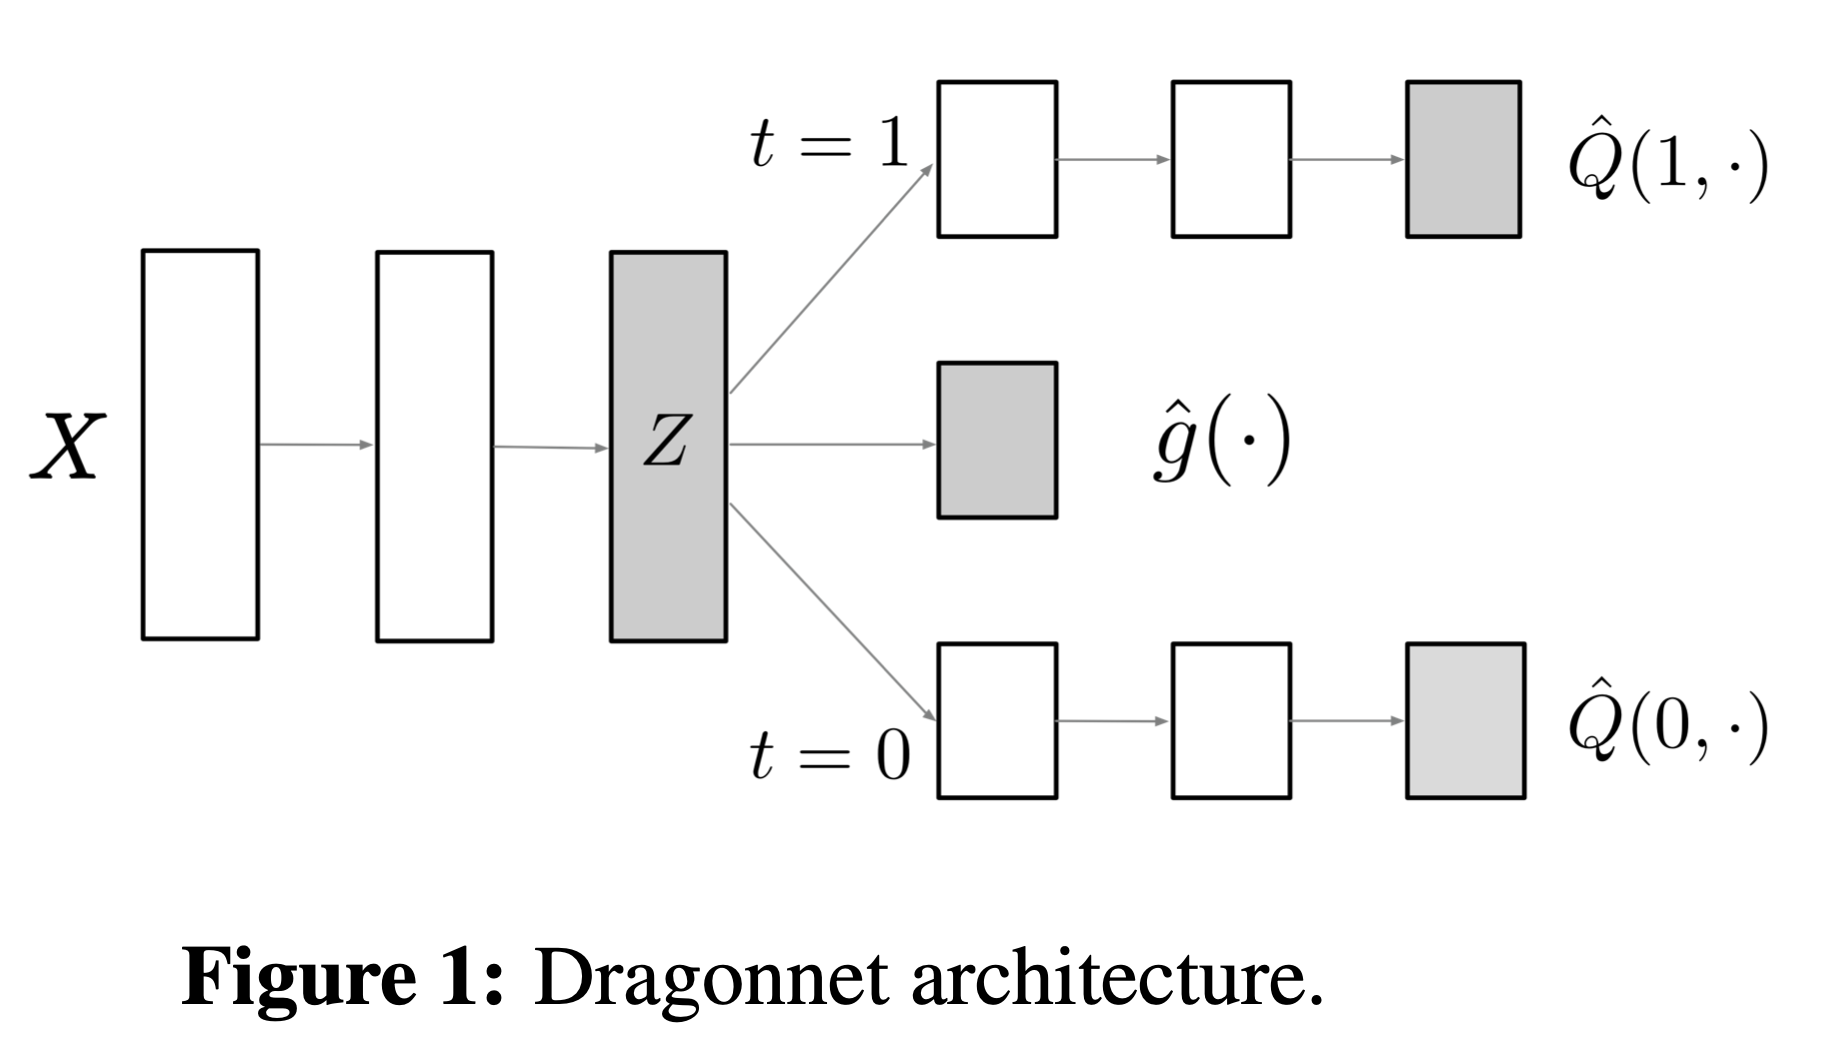

In [1]:
from IPython import display
import os
os.chdir('/Users/alinaxu/Documents/CDM/CausalDM')
display.Image("./images/CEL-SingleStage-Dragonnet.png", width=500)

By first training the propensity score model through several layers of neural network, we are able to capture the resourceful information of $g(S)$ in layer $Z$. The core idea of Dragonnet is to directly utilize the information in $Z$ to fit outcome regression models for $\hat{Q}(1,s)$ and $\hat{Q}(0,s)$.

The objective function of Dragonnet is given by
\begin{equation}
\hat{\theta}=\arg\min_{\theta} \frac{1}{n}\sum_{i}\Big[(Q^{\text{nn}}(a_i,s_i;\theta)-R_i)^2+\alpha \text{CrossEntropy}(g^{\text{nn}}(s_i,\theta),a_i)\Big],
\end{equation}
where $\theta$ is the collection of all parameters, and $\alpha$ is a weighting hyperparameter.



#### Part 2. Targeted Regularization


In targeted regularization, the author modified the objective function to yield a better finite sample performance. Specifically, the author defined
\begin{equation}
\begin{aligned}
& \tilde{Q}(a_i,s_i;\theta,\epsilon) = {Q}^{\text{nn}}(a_i,s_i;\theta)+\epsilon, \bigg[\frac{a_i}{g^{\text{nn}}(s_i;\theta)}-\frac{1-a_i}{1-g^{\text{nn}}(s_i;\theta)}\bigg]\\
& \gamma(R_i,a_i,s_i;\theta,\epsilon) = (R_i-\tilde{Q}(a_i,s_i;\theta,\epsilon))^2,
\end{aligned}
\end{equation}
and then train the model by minimizing a new objective function with an extra parameter $\epsilon$ as below:
\begin{equation}
\hat{\theta},\hat{\epsilon} = \arg\min_{\theta,\epsilon} \Big[\hat{R}(\theta,S)+\beta\frac{1}{n}\sum_{i} \gamma(R_i,a_i,s_i;\theta,\epsilon)\Big],
\end{equation}
where $\beta$ is another weighting hyperparameter.

The final treatment effect estimator, after targeted regularization, is given by
\begin{equation}
\widehat{\text{HTE}}_{\text{Dragonnet}}(s)=\tilde{Q}(1,s;\hat\theta,\hat\epsilon)-\tilde{Q}(0,s;\hat\theta,\hat\epsilon),
\end{equation}
where $(\hat\theta,\hat\epsilon)$ is the solution we obtained above.


**Note**: The simulation code of Dragonnet is available at https://github.com/claudiashi57/dragonnet. To check its performance, we apply this method on MovieLens data for a primary illustration.

In [2]:
# The code is available at https://github.com/claudiashi57/dragonnet
# import related packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt;
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from causaldm.learners.CEL.Single_Stage import _env_getdata_CEL
from causaldm.learners.CEL.Single_Stage.Dragonnet import *
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name '_env_getdata_CEL' from 'causaldm.learners.CEL.Single_Stage' (/Users/alinaxu/Documents/CDM/CausalDM/causaldm/learners/CEL/Single_Stage/__init__.py)

### MovieLens Data

In [5]:
# Get data
#MovieLens_CEL = pd.read_csv("./causaldm/data/MovieLens_CEL.csv")
MovieLens_CEL = get_movielens_CEL()
MovieLens_CEL.pop(MovieLens_CEL.columns[0])
MovieLens_CEL = MovieLens_CEL[MovieLens_CEL.columns.drop(['Comedy','Action', 'Thriller'])]
MovieLens_CEL

,user_id,movie_id,rating,age,Drama,Sci-Fi,gender_M,occupation_academic/educator,occupation_college/grad student,occupation_executive/managerial,occupation_other,occupation_technician/engineer
0,48.0,1193.0,4.0,25.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,48.0,919.0,4.0,25.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,48.0,527.0,5.0,25.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,48.0,1721.0,4.0,25.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,48.0,150.0,4.0,25.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
65637,5878.0,3300.0,2.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
65638,5878.0,1391.0,1.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
65639,5878.0,185.0,4.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
65640,5878.0,2232.0,1.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
n = len(MovieLens_CEL)
userinfo_index = np.array([3,6,7,8,9,10,11])
S = MovieLens_CEL.iloc[:, userinfo_index]
#SandA = MovieLens_CEL.iloc[:, np.array([3,4,5,6,7,8,9,10])]

In [14]:
test_outputs, train_output = train_and_predict_dragons(MovieLens_CEL['Drama'].to_numpy().reshape(-1,1),MovieLens_CEL['rating'].to_numpy().reshape(-1,1), S.to_numpy(),
                                                       targeted_regularization=True,
                                                       output_dir='/Users/alinaxu/Downloads/dragonnet-master/result',
                                                       knob_loss=dragonnet_loss_binarycross, ratio=1., dragon='dragonnet',
                                                       val_split=0.2, batch_size=64)

I am here making dragonnet
***************************** elapsed_time is:  285.40207719802856
2031/2031 [==============================] - 2s 964us/step
average propensity for treated: 0.7404845356941223 and untreated: 0.7264252305030823
average propensity for treated: 0.7404845356941223 and untreated: 0.7264252305030823


In [9]:
# the output keys
train_output[0].keys()

dict_keys(['q_t0', 'q_t1', 'g', 't', 'y', 'x', 'index', 'eps'])

In [10]:
HTE_Dragonnet = train_output[0]['q_t1'] - train_output[0]['q_t0']

Let's focus on the estimated HTEs for three randomly chosen users:

In [11]:
print("Dragonnet:  ",HTE_Dragonnet[0][np.array([0,1000,5000])])

Dragonnet:   [0.34005857 0.33967185 0.46262145]


In [12]:
# Calculate the Aaverage Treatment Effect by Dragonnet
ATE_Dragonnet = np.sum(HTE_Dragonnet)/n
print("Choosing Drama instead of Sci-Fi is expected to improve the rating of all users by",round(ATE_Dragonnet,4), "out of 5 points.")

Choosing Drama instead of Sci-Fi is expected to improve the rating of all users by 0.3526 out of 5 points.


**Conclusion:** Choosing Drama instead of Sci-Fi is expected to improve the rating of all users by 0.3526 out of 5 points.

## References

8. Claudia Shi, David M. Blei, and Victor Veitch. Adapting Neural Networks for the Estimation of
Treatment Effects. 33rd Conference on Neural Information Processing Systems (NeurIPS 2019).

9. Chernozhukov, V., D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, and
J. Robins (2018). Double/debiased machine learning for treatment and structural parameters.